In [8]:
# Needed libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt  # For visualizations
import seaborn as sns  # For visualizations
from scipy.stats import chi2_contingency, ttest_ind  # For chi-square and t-tests
import statsmodels.api as sm  # For regression analysis
from statsmodels.formula.api import ols  # For regression test
from statsmodels.stats.multicomp import pairwise_tukeyhsd # For post-hoc testing

In [9]:
# Load all XPT files
demo = pd.read_sas('/content/DEMO_L.xpt', format='xport')
bpxo = pd.read_sas('/content/BPXO_L.xpt', format='xport')
vid = pd.read_sas('/content/VID_L.xpt', format='xport')
hepb = pd.read_sas('/content/HEPB_S_L.xpt', format='xport')
kiq = pd.read_sas('/content/KIQ_U_L.xpt', format='xport')
paq = pd.read_sas('/content/PAQ_L.xpt', format='xport')
whq = pd.read_sas('/content/WHQ_L.xpt', format='xport')

# I originally used the code below to clean the data, but it produced an error message which said "SettingWithCopyWarning: A value is trying to be set on a copy of a slice from a DataFrame.". Adding .copy[] fixed this

# demo_clean = demo[(demo.DMDMARTZ.notna()) &
#                   (demo.DMDMARTZ != 77) &
#                   (demo.DMDMARTZ != 99) &
#                   (demo.DMDEDUC2.notna()) &
#                   (demo.DMDEDUC2 != 7) &
#                   (demo.DMDEDUC2 != 9) &
#                   (demo.RIDAGEYR.notna())]

# Clean Blood Pressure: Remove missing systolic and diastolic readings
# bpxo_clean = bpxo[(bpxo.BPXOSY3.notna()) &
#                   (bpxo.BPXODI3.notna())]

# Clean Vitamin D: Remove missing values
# vid_clean = vid[vid.LBDVD2LC.notna()]

# Clean Hepatitis B: Remove missing values
# hepb_clean = hepb[hepb.LBXHBS.notna()]

# # Clean Kidney: Remove refused/don't know and missing values
# kiq_clean = kiq[(kiq.KIQ022.notna()) &
#                 (kiq.KIQ022 != 7) &
#                 (kiq.KIQ022 != 9)]

# Clean Physical Activity: Remove refused/don't know and missing for sedentary behavior
# paq_clean = paq[(paq.PAD680.notna()) &
#                 (paq.PAD680 != 7777) &
#                 (paq.PAD680 != 9999)]

# Clean Weight History: Remove refused/don't know and missing for weight
# whq_clean = whq[(whq.WHD020.notna()) &
#                 (whq.WHD020 != 7777) &
#                 (whq.WHD020 != 9999)]


# To fix this, I added .copy[] to the new code

# Data Cleaning
# Clean Demographics: Remove refused/don't know for marital status and education
demo_clean = demo[(demo.DMDMARTZ.notna()) &
                  (demo.DMDMARTZ != 77) &
                  (demo.DMDMARTZ != 99) &
                  (demo.DMDEDUC2.notna()) &
                  (demo.DMDEDUC2 != 7) &
                  (demo.DMDEDUC2 != 9) &
                  (demo.RIDAGEYR.notna())].copy()

# Clean Blood Pressure: Remove missing systolic and diastolic readings
bpxo_clean = bpxo[(bpxo.BPXOSY3.notna()) &
                  (bpxo.BPXODI3.notna())].copy()

# Clean Vitamin D: Remove missing values
vid_clean = vid[vid.LBDVD2LC.notna()].copy()

# Clean Hepatitis B: Remove missing values
hepb_clean = hepb[hepb.LBXHBS.notna()].copy()

# Clean Kidney: Remove refused/don't know and missing values
kiq_clean = kiq[(kiq.KIQ022.notna()) &
                (kiq.KIQ022 != 7) &
                (kiq.KIQ022 != 9)].copy()

# Clean Physical Activity: Remove refused/don't know and missing for sedentary behavior
paq_clean = paq[(paq.PAD680.notna()) &
                (paq.PAD680 != 7777) &
                (paq.PAD680 != 9999)].copy()

# Clean Weight History: Remove refused/don't know and missing for weight
whq_clean = whq[(whq.WHD020.notna()) &
                (whq.WHD020 != 7777) &
                (whq.WHD020 != 9999)].copy()


In [10]:
# QUESTION 1: Is there an association between marital status (married or not married) and education level (bachelor’s degree or higher vs. less than a bachelor’s degree)?

# Method of analysis: Chi-Square test
# Method justification: Since marital status and education level are categorical variables, a Chi-Square test is best.
# IV = Marital Status (categorical)
# DV = Education Level (categorical)
# Results: X-squared = 129.17, df = 1, p-value < 2.2e-16
# Interpretation of results and conclusion: Married individuals are more likely to have a bachelor's degree or higher compared to those who are not married. P value confirms that there is a highly significant association between marital status and education level.

# DATA RECODING (Data already cleaned in Cell 2)

# Recoded Marital Status (DMDMARTZ): 1 = Married/Living With Partner, 2-6 = Various Non-Married Statuses
demo_clean['marital_binary'] = demo_clean['DMDMARTZ'].apply(
    lambda x: 'Married' if x == 1 else 'Not Married'
)

# Recoded Education Level (DMDEDUC2): 5 = Bachelor's or higher, 1-4 = Less than Bachelor's
demo_clean['education_binary'] = demo_clean['DMDEDUC2'].apply(
    lambda x: "Bachelor's or Higher" if x == 5 else "Less than Bachelor's"
)

# Contingency table
contingency_table = pd.crosstab(demo_clean['marital_binary'], demo_clean['education_binary'])
print("\nContingency Table:")
print(contingency_table)

# Chi-Square test
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

# Print results
print(f"\nChi-Square Test Results:")
print(f"Chi-Square Statistic: {chi2:.2f}")
print(f"P-value: {p_value}")
print(f"Degrees of Freedom: {dof}")



Contingency Table:
education_binary  Bachelor's or Higher  Less than Bachelor's
marital_binary                                              
Married                           1631                  2503
Not Married                        990                  2648

Chi-Square Test Results:
Chi-Square Statistic: 129.17
P-value: 6.213197986632679e-30
Degrees of Freedom: 1


In [11]:
# QUESTION 2: Is there a difference in the mean sedentary behavior time between those who are married and those who are not married?

# Method of analysis: T-test
# Method justification: We're comparing the mean of a continuous variable (sedentary minutes) between two groups (married vs not married).
# IV = Martial status (categorical, 2 groups)
# DV = Sedentary behavior time (continuous)
# Results: t = -3.8609, df = 7385.2, p-value = 0.0001139, Mean (Married): 353.2108 minutes, Mean (Not Married): 371.9341 minutes
# Interpretation of results and conclusion: Non-married individuals spend more time in sedentary behavior (approximately 19 minutes more per day on average) compared to married individuals. P value confirms a statistically significant difference in sedentary behavior between married and not married individuals.

# Recoded marital status (like in cell 3)
demo_clean['marital_binary'] = demo_clean['DMDMARTZ'].apply(
    lambda x: 'Married' if x == 1 else 'Not Married'
)

# Merged demo_clean + paq_clean by SEQN
q2_data = demo_clean.merge(paq_clean, on='SEQN', how='inner')

# Subset data by marital status
married_sedentary = q2_data[q2_data['marital_binary'] == 'Married']['PAD680']  # Sedentary time for married
not_married_sedentary = q2_data[q2_data['marital_binary'] == 'Not Married']['PAD680']  # Sedentary time for not married

# Calculated means
married_mean = married_sedentary.mean()  # Average sedentary time for married
not_married_mean = not_married_sedentary.mean()  # Average sedentary time for not married

print(f"Mean (Married): {married_mean:.4f} minutes")
print(f"Mean (Not Married): {not_married_mean:.4f} minutes")

# T-Test
t_stat, p_value = ttest_ind(married_sedentary, not_married_sedentary, equal_var=False)

# Print results
print(f"\nT-Test Results:")
print(f"t-statistic: {t_stat:.4f}")
print(f"p-value: {p_value}")

Mean (Married): 353.2108 minutes
Mean (Not Married): 371.9341 minutes

T-Test Results:
t-statistic: -3.8609
p-value: 0.00011393877230144084


                            OLS Regression Results                            
Dep. Variable:                BPXOSY3   R-squared:                       0.134
Model:                            OLS   Adj. R-squared:                  0.134
Method:                 Least Squares   F-statistic:                     452.9
Date:                Fri, 07 Nov 2025   Prob (F-statistic):          1.50e-183
Time:                        21:09:13   Log-Likelihood:                -24844.
No. Observations:                5835   AIC:                         4.969e+04
Df Residuals:                    5832   BIC:                         4.971e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

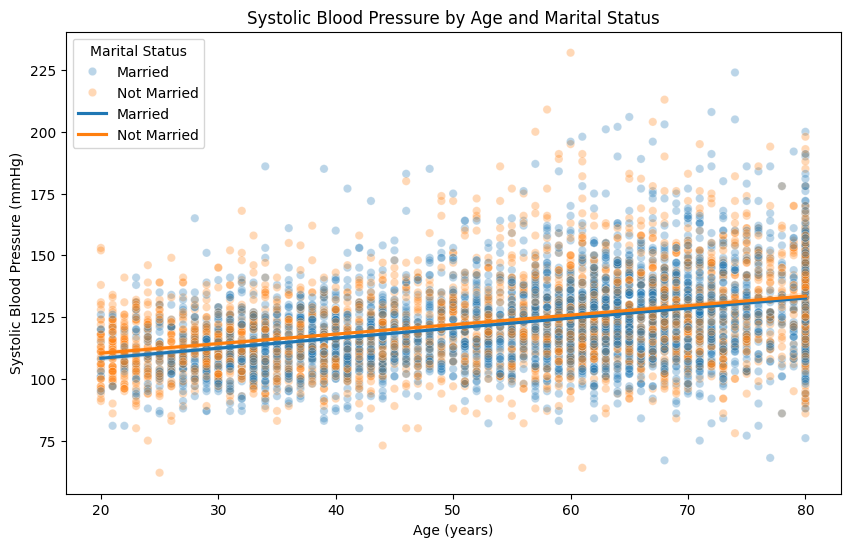

In [12]:
# QUESTION 3: How do age and marital status affect systolic blood pressure?

# Method of analysis: Multiple Linear Regression
# Method justification: MLR is best because we have one continuous (age) and one categorical (marital status) predictor affecting a continuous outcome.
# IV = Age (continuous) and Marital status (categorical)
# DV = Systolic blood pressure (continuous)
# Results for Age
    # Coefficient = 0.39524
    # Standard error = 0.01314
    # P-value < 2e-16 (highly significant)
# Interpretation: Systolic BP increases with age
# Results for Marital Status (Not Married vs Married):
    # Coefficient = 1.34909
    # Standard error = 0.45110
    # P-value = 0.0028
# Interpretation: Systolic BP is higher in non-married individuals than married individuals.
    # Residual standard error: 17.1 on 5832 degrees of freedom
    # R-squared results: 0.1344 (13.44%) variance in systolic blood pressure
    # Overall model F-statistic: 452.9 on 2 and 5832 DF
    # Overall model p-value: < 2.2e-16
# Interpretation of results and conclusion: Both age and marital status are significant predictors of systolic blood pressure with age being the dominant predictor. Increased age is associated with higher BP and so is non-married status.

# Recoded marital status like in cell 3
demo_clean['marital_binary'] = demo_clean['DMDMARTZ'].apply(
    lambda x: 'Married' if x == 1 else 'Not Married'
)

# Merged demo_clean + bpxo_clean by SEQN
q3_data = demo_clean.merge(bpxo_clean, on='SEQN', how='inner')

# Multiple Linear Regression
model = ols('BPXOSY3 ~ RIDAGEYR + C(marital_binary)', data=q3_data).fit()
print(model.summary())

# Visualization (scatterplot)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=q3_data, x='RIDAGEYR', y='BPXOSY3', hue='marital_binary', alpha=0.3)
sns.regplot(data=q3_data[q3_data['marital_binary'] == 'Married'],
            x='RIDAGEYR', y='BPXOSY3', scatter=False, label='Married')
sns.regplot(data=q3_data[q3_data['marital_binary'] == 'Not Married'],
            x='RIDAGEYR', y='BPXOSY3', scatter=False, label='Not Married')
plt.title('Systolic Blood Pressure by Age and Marital Status')
plt.xlabel('Age (years)')
plt.ylabel('Systolic Blood Pressure (mmHg)')
plt.legend(title='Marital Status')
plt.show()

In [13]:
# QUESTION 4: Is there a correlation between self-reported weight and minutes of sedentary behavior?

# Method of analysis: Simple Linear Regression
# Method justification: We're examining if one continuous variable (weight) predicts another continuous variable (sedentary time).
# IV = Self-reported weight (continuous)
# DV = Sedentary behavior time (continuous)
# Results:
    # Intercept: 239.32 minutes
    # Weight coefficient: 0.68 minutes per pound
# Interpretation: Sedentary time increases with weight
    # P-value: < 2.2e-16 (highly significant)
    # R-squared: 0.02433 (2.43%)
    # Interpretation: Weight explains only 2.43% of the variance in sedentary behavior
    # F-statistic: 198.3 on 1 and 7952 DF,  p-value: < 2.2e-16
# Interpretation of results and conclusion: Weight is a statistically significant predictor of sedentary behavior (~p < 0.001). As weight increases, sedentary behavior time also increases.

# Merged whq_clean + paq_clean by SEQN
q4_data = whq_clean.merge(paq_clean, on='SEQN', how='inner')

# Defined independent and dependent variables
X = q4_data['WHD020']
y = q4_data['PAD680']

# Added constant (intercept) to the model
X = sm.add_constant(X)

# Simple Linear Regression
model_q4 = sm.OLS(y, X).fit()
print(model_q4.summary())

                            OLS Regression Results                            
Dep. Variable:                 PAD680   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     198.3
Date:                Fri, 07 Nov 2025   Prob (F-statistic):           1.70e-44
Time:                        21:09:14   Log-Likelihood:                -53698.
No. Observations:                7954   AIC:                         1.074e+05
Df Residuals:                    7952   BIC:                         1.074e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        239.3241      9.010     26.563      0.0

ANOVA Results:
                   sum_sq      df          F        PR(>F)
C(DMDEDUC2)  1.113974e+07     4.0  64.334109  1.358073e-53
Residual     3.330627e+08  7694.0        NaN           NaN

Tukey HSD Post-hoc Test:
     Multiple Comparison of Means - Tukey HSD, FWER=0.05      
 group1     group2    meandiff p-adj   lower    upper   reject
--------------------------------------------------------------
  9-11th        < 9th -57.3979 0.0003 -94.6494 -20.1463   True
  9-11th     College+  82.9761    0.0  58.1097 107.8425   True
  9-11th       HS/GED   7.3446 0.9398 -18.7527  33.4419  False
  9-11th Some College  40.9174 0.0001  15.7657  66.0692   True
   < 9th     College+  140.374    0.0 108.4993 172.2486   True
   < 9th       HS/GED  64.7425    0.0  31.8985  97.5864   True
   < 9th Some College  98.3153    0.0  66.2176  130.413   True
College+       HS/GED -75.6315    0.0 -93.2208 -58.0421   True
College+ Some College -42.0587    0.0 -58.2118 -25.9055   True
  HS/GED Some College  33.

<Figure size 1000x600 with 0 Axes>

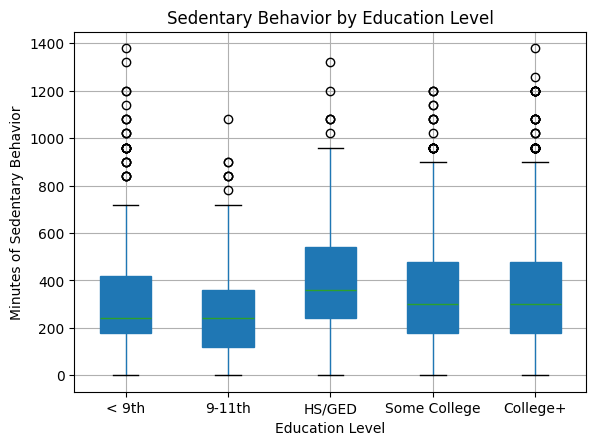

In [14]:
# QUESTION 5: Does sedentary behavior differ by education level?

# Variables used: DMDEDUC2 and PAD680
# Method of analysis: One-way ANOVA
# Method justification: One-way ANOVA is best because we are examining the effect of one independent variable (education level with 5 categories) on one dependent variable (sedentary behavior).
# IV = Education level (categorical)
# DV = Sedentary time (continous)
# Results: F-statistic:** 64.16, Degrees of freedom: 4 and 7703, P-value:< 2e-16
  # Mean sedentary time by education level:
    # Less than 9th grade (1): 264.98 minutes (about 4.4 hours)
    # 9th-11th grade (2): 322.38 minutes (about 5.4 hours)
    # High School/GED (3): 329.72 minutes (about 5.5 hours)
    # Some College (4): 363.30 minutes (about 6.1 hours)
    # College graduate or higher (5): 405.36 minutes (about 6.8 hours)
# Interpretation of results and conclusion: There is a highly statistically significant difference in mean sedentary behavior time across education levels. Sedentary behavior time increases with higher education levels. This might be because college graduates are more likely to work desk jobs which come with a sedentary work environment.


# Merged demo_clean + paq_clean by SEQN
q5_data = demo_clean.merge(paq_clean, on='SEQN', how='inner')  # Combine datasets by participant ID

# Converted education to labeled categories
q5_data['education_label'] = q5_data['DMDEDUC2'].map({
    1: "< 9th",
    2: "9-11th",
    3: "HS/GED",
    4: "Some College",
    5: "College+"
})

# One-Way ANOVA test
model_anova = ols('PAD680 ~ C(DMDEDUC2)', data=q5_data).fit()  # Fit ANOVA model
anova_table = sm.stats.anova_lm(model_anova, typ=2)  # Generate ANOVA table
print("ANOVA Results:")
print(anova_table)

# Post-hoc Tukey HSD test
tukey = pairwise_tukeyhsd(endog=q5_data['PAD680'], groups=q5_data['education_label'], alpha=0.05)  # Compare all pairs
print("\nTukey HSD Post-hoc Test:")
print(tukey)

# Calculated mean sedentary time for each education group
means = q5_data.groupby('education_label')['PAD680'].mean()
print("\nMean Sedentary Time by Education Level:")
print(means)

# Visualization
plt.figure(figsize=(10, 6))
q5_data.boxplot(column='PAD680', by='education_label',
                positions=[0, 1, 2, 3, 4],
                patch_artist=True)
plt.title('Sedentary Behavior by Education Level')
plt.suptitle('')
plt.xlabel('Education Level')
plt.ylabel('Minutes of Sedentary Behavior')
plt.xticks([0, 1, 2, 3, 4], ["< 9th", "9-11th", "HS/GED", "Some College", "College+"])
plt.show()